In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def normalize_time(df):
    df = df.copy()
    df['t'] = df['t'] - df['t'].iloc[0]
    return df

def normalize_angles(df, angle_column, new_column='r_ang'):
    """
    Normaliza los ángulos a un rango [0, 360) y los convierte a radianes.

    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene la columna de ángulos.
    angle_column (str): Nombre de la columna que contiene los ángulos en grados.
    new_column (str): Nombre de la nueva columna con los ángulos normalizados en radianes.

    Retorna:
    pd.DataFrame: El DataFrame con la nueva columna añadida.
    """
    df[new_column] = np.deg2rad(df[angle_column] % 360)
    return df

def deg_to_rad(df, col_deg='v_ang', col_rad='v_ang'):
    """
    Convierte una columna de velocidad angular de grados/s a radianes/s.

    Parámetros:
    df (pd.DataFrame): DataFrame con la columna en grados/s.
    col_deg (str): Nombre de la columna de entrada en grados/s.
    col_rad (str): Nombre de la columna de salida (puede sobrescribir).

    Retorna:
    pd.DataFrame: El DataFrame con la columna convertida a rad/s.
    """
    df[col_rad] = np.deg2rad(df[col_deg])
    return df

def angular_momentum(df, mass_kg, r_col='r', omega_col='v_ang', new_col='L'):
    """
    Calcula el momento angular: L = m * r² * ω, ignorando filas con valores nulos.

    Parámetros:
    df (pd.DataFrame): DataFrame con las columnas necesarias.
    mass_kg (float): Masa en kilogramos.
    r_col (str): Nombre de la columna del radio (en metros).
    omega_col (str): Nombre de la columna de velocidad angular (en rad/s).
    new_col (str): Nombre de la nueva columna para el momento angular.

    Retorna:
    pd.DataFrame: DataFrame con la nueva columna del momento angular (nulos si r o ω son nulos).
    """
    df[new_col] = mass_kg * (df[r_col]**2) * df[omega_col]
    return df

def initial_force_smooth(df, mass_kg, a_col='a', t_col='t', t_max=0.3):
    """
    Estima la fuerza inicial en un sistema con aplicación suave,
    promediando la aceleración durante los primeros `t_max` segundos.

    Parámetros:
    df (pd.DataFrame): DataFrame con columnas de tiempo y aceleración.
    mass_kg (float): Masa del objeto en kilogramos.
    a_col (str): Nombre de la columna de aceleración (m/s²).
    t_col (str): Nombre de la columna de tiempo (s).
    t_max (float): Tiempo máximo para el promedio inicial (s).

    Retorna:
    float: Estimación de la fuerza inicial en Newtons.
    """
    df_valid = df[[t_col, a_col]].dropna()
    df_initial = df_valid[df_valid[t_col] <= t_max]

    if df_initial.empty:
        raise ValueError("No hay datos suficientes en el rango de tiempo inicial.")

    a_prom = df_initial[a_col].mean()
    F_init = mass_kg * a_prom
    return F_init

def radius_decay_constant(df, t_col='t', r_col='r'):
    """
    Estima la constante de decaimiento del radio: r(t) = r0 * exp(-λ t)

    Parámetros:
    df (pd.DataFrame): DataFrame con columnas de tiempo y radio.
    t_col (str): Nombre de la columna de tiempo.
    r_col (str): Nombre de la columna del radio.

    Retorna:
    tuple: (r0, lambda) parámetros ajustados
    """
    df_valid = df[[t_col, r_col]].dropna()
    t = df_valid[t_col].values
    r = df_valid[r_col].values

    def exp_decay(t, r0, lamb):
        return r0 * np.exp(-lamb * t)

    popt, _ = curve_fit(exp_decay, t, r, p0=[r[0], 0.01])
    r0_fit, lambda_fit = popt
    return r0_fit, lambda_fit

def omega_model(t, w0, beta):
    return w0 * np.exp(-beta * t)

def estimate_initial_omega(df, t_col='t', omega_col='v_ang', t_max=0.3):
    """
    Estima el valor inicial de omega (velocidad angular) como el promedio
    durante los primeros `t_max` segundos.

    Parámetros:
    df (pd.DataFrame): DataFrame con columnas de tiempo y velocidad angular.
    t_col (str): Nombre de la columna de tiempo.
    omega_col (str): Nombre de la columna de velocidad angular (rad/s).
    t_max (float): Tiempo máximo para promedio inicial (s).

    Retorna:
    float: Estimación de omega₀ (rad/s)
    """
    df_valid = df[[t_col, omega_col]].dropna()
    df_initial = df_valid[df_valid[t_col] <= t_max]

    if df_initial.empty:
        raise ValueError("No hay datos suficientes en el rango inicial.")

    omega_0 = df_initial[omega_col].mean()
    return omega_0

def estimate_rotational_friction(df, mass_kg, t_col='t', omega_col='v_ang', r_col='r'):
    # Filtrar datos válidos
    df_valid = df[[t_col, omega_col, r_col]].dropna()
    t = df_valid[t_col].values
    omega = df_valid[omega_col].values
    r = df_valid[r_col].values

    # Ajustar modelo exponencial a omega(t)
    popt, _ = curve_fit(omega_model, t, omega, p0=[omega[0], 0.1])
    w0, beta = popt

    # Estimar k usando el promedio de r² (ya que r puede variar)
    r_sq_mean = np.mean(r**2)
    k = mass_kg * r_sq_mean * beta

    return {
        'omega_0': w0,
        'beta': beta,
        'k': k
    }

In [3]:
rdf_mcua = pd.read_csv("data/mcua.csv")
rdf_ml1 = pd.read_csv("data/ml1.csv")
rdf_ml2 = pd.read_csv("data/ml2.csv")

In [4]:
rdf_mcua.head()

,t,r,v,a,ang,v_ang
0,2.673,0.180,NaN,NaN,0.0,NaN
1,2.690,0.180,0.937,NaN,-4.5,-297.9
2,2.707,0.181,1.309,23.51,-10.0,-417.2
3,2.723,0.181,1.709,26.39,-18.5,-544.6
4,2.740,0.180,1.983,21.04,-28.3,-634.5


In [5]:
rdfs = [rdf_mcua, rdf_ml1, rdf_ml2]
dfs = []

for df in rdfs:
    df = normalize_time(df)
    df["ang"] = -df["ang"]
    df["v_ang"] = -df["v_ang"]
    df = normalize_angles(df, "ang")
    df = angular_momentum(df, 0.0502)
    df = deg_to_rad(df, "v_ang")
    dfs.append(df)

In [6]:
for df in dfs:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1040 non-null   float64
 1   r       1040 non-null   float64
 2   v       1038 non-null   float64
 3   a       1036 non-null   float64
 4   ang     1040 non-null   float64
 5   v_ang   1038 non-null   float64
 6   r_ang   1040 non-null   float64
 7   L       1038 non-null   float64
dtypes: float64(8)
memory usage: 65.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       169 non-null    float64
 1   r       169 non-null    float64
 2   v       167 non-null    float64
 3   a       165 non-null    float64
 4   ang     169 non-null    float64
 5   v_ang   167 non-null    float64
 6   r_ang   169 non-null    float64
 7   L       167 non-null    float64
dtypes: f

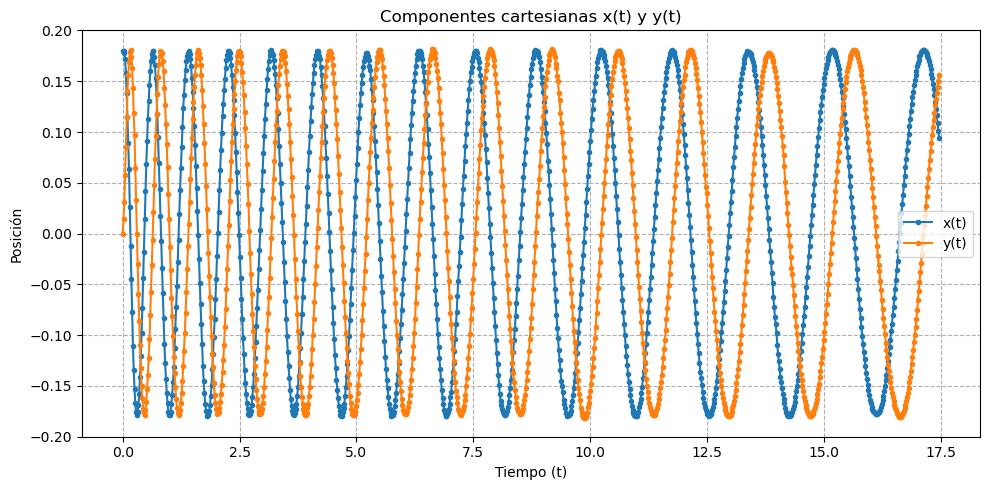

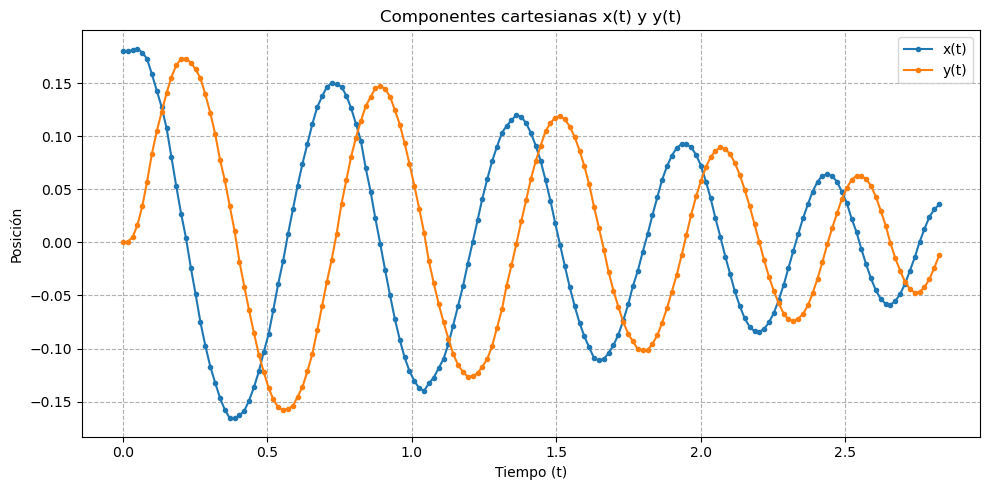

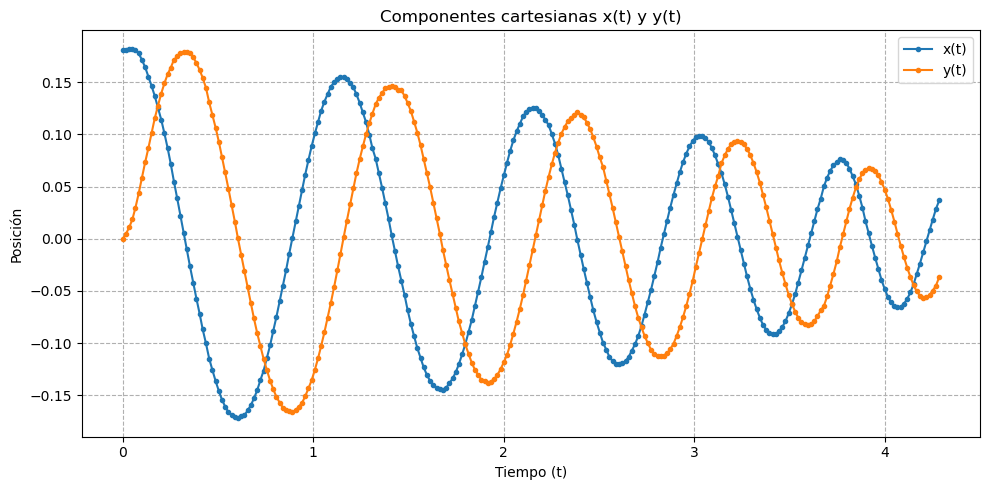

In [7]:
for df in dfs:
    df['x'] = df['r'] * np.cos(df['r_ang'])
    df['y'] = df['r'] * np.sin(df['r_ang'])

    # Graficar x(t) y y(t)
    plt.figure(figsize=(10, 5))
    plt.plot(df['t'], df['x'], label='x(t)', linestyle='-', marker='.')
    plt.plot(df['t'], df['y'], label='y(t)', linestyle='-', marker='.')
    plt.xlabel('Tiempo (t)')
    plt.ylabel('Posición')
    plt.title('Componentes cartesianas x(t) y y(t)')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

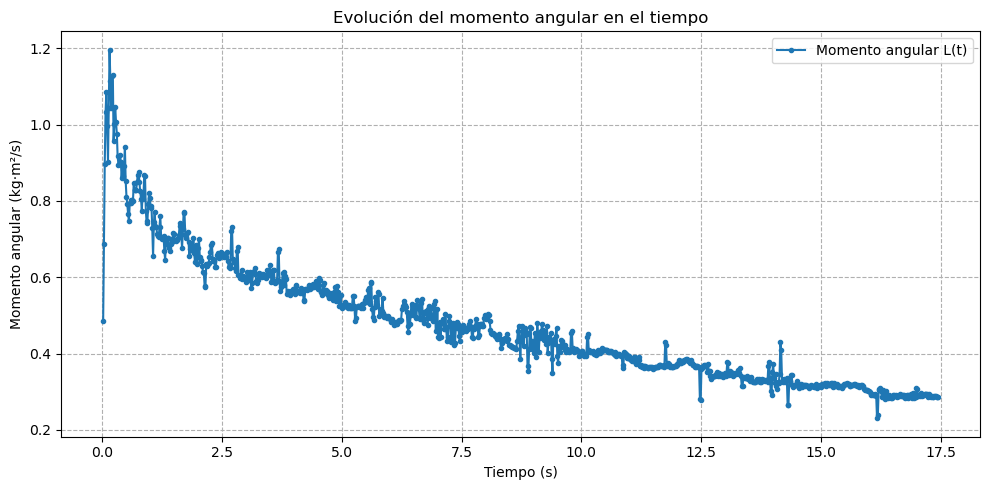

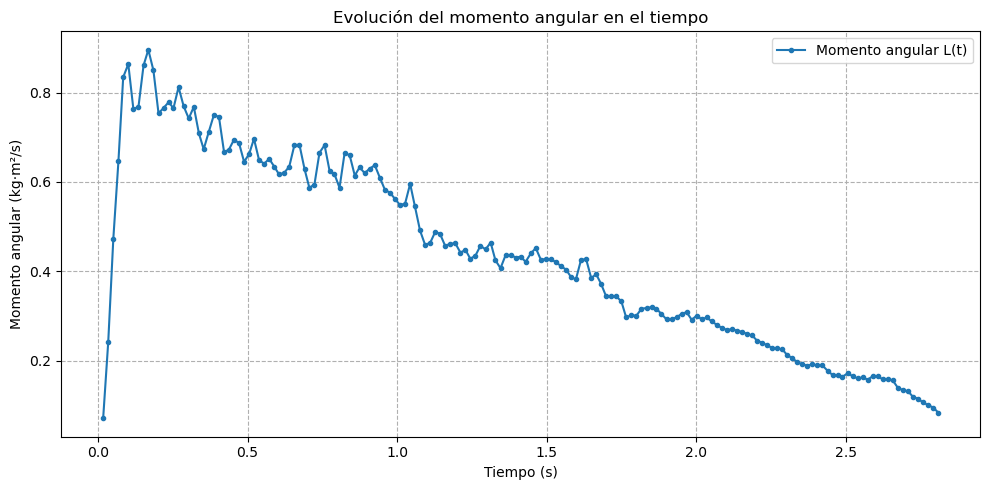

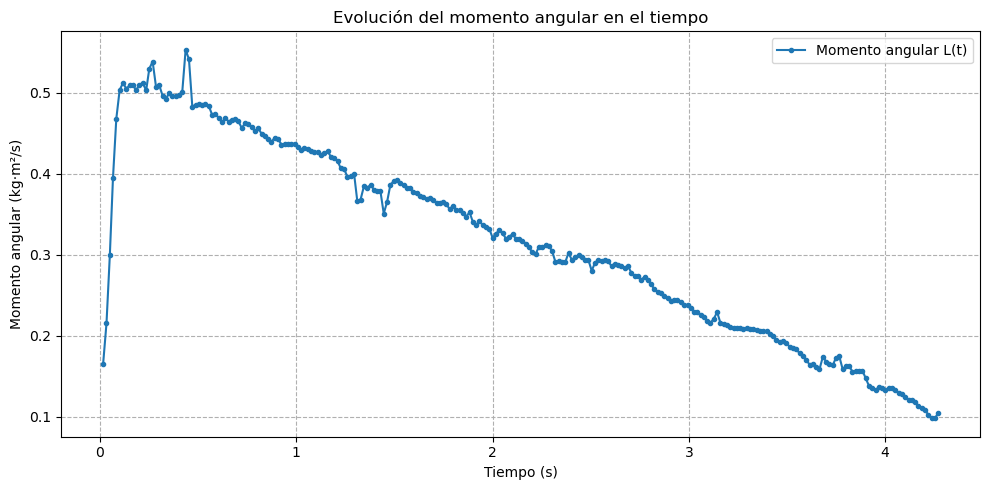

In [8]:
for df in dfs:
    plt.figure(figsize=(10, 5))
    plt.plot(df['t'], df['L'], label='Momento angular L(t)', marker='.')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Momento angular (kg·m²/s)')
    plt.title('Evolución del momento angular en el tiempo')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

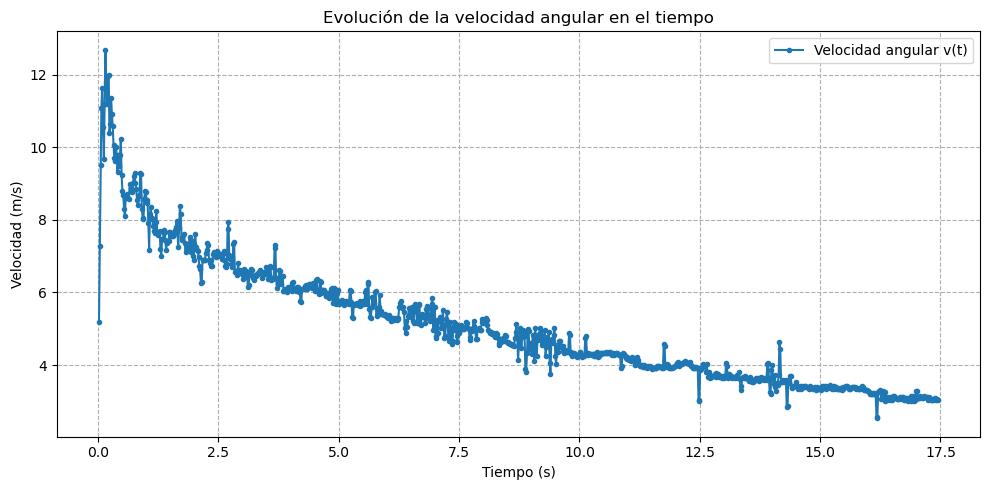

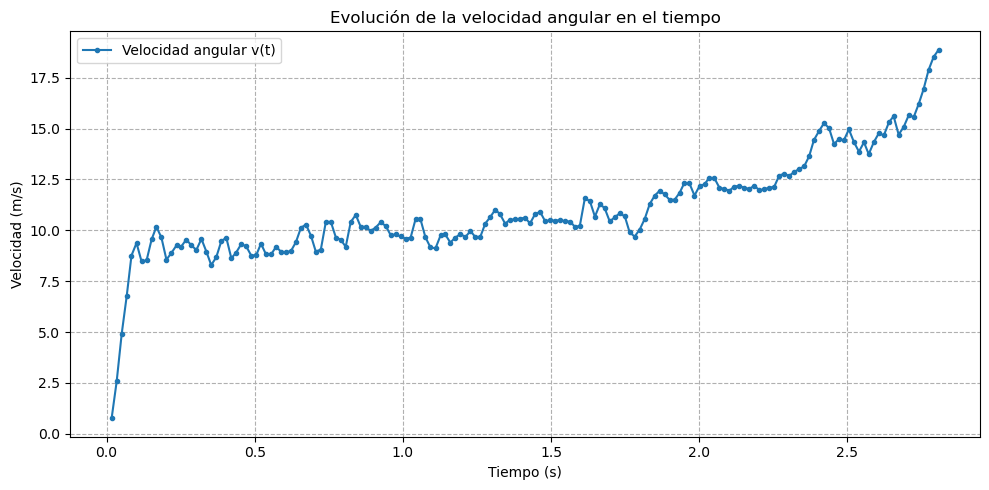

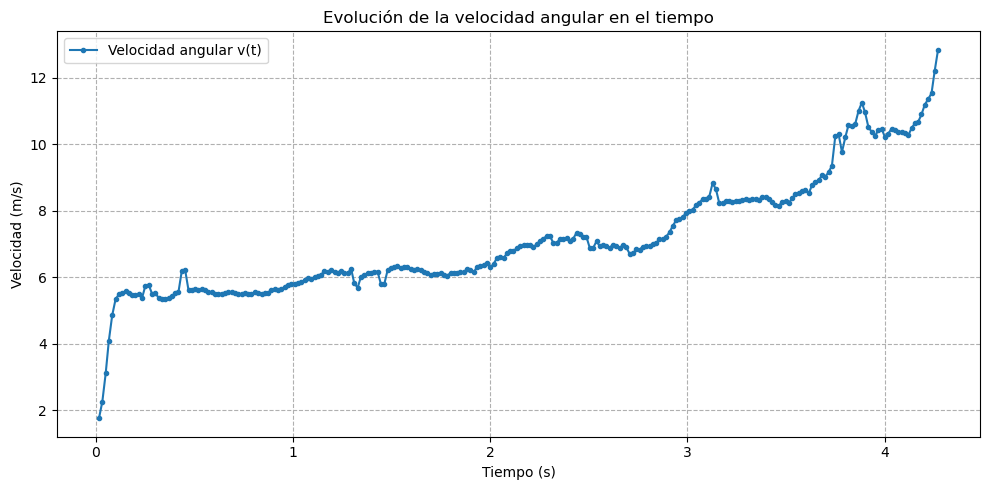

In [9]:
for df in dfs:
    plt.figure(figsize=(10, 5))
    plt.plot(df['t'], df['v_ang'], label='Velocidad angular v(t)', linestyle='-', marker='.')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Velocidad (m/s)')
    plt.title('Evolución de la velocidad angular en el tiempo')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
params = estimate_rotational_friction(dfs[0], mass_kg=0.0502)
print(f"ω₀: {params['omega_0']:.4f} rad/s")
print(f"β (decaimiento): {params['beta']:.4f} 1/s")
print(f"Coef. fricción rotacional k: {params['k']:.6f} N·m·s")

ω₀: 8.5916 rad/s
β (decaimiento): 0.0664 1/s
Coef. fricción rotacional k: 0.000108 N·m·s


In [11]:
f_aplicada = initial_force_smooth(dfs[0], mass_kg=0.0502, t_max=0.3)
print(f"Fuerza inicial estimada (suave): {f_aplicada:.6f} N")

Fuerza inicial estimada (suave): 1.166774 N


In [12]:
# --- Datos experimentales ---
df = dfs[0]                    # Primer DataFrame con datos reales
t_exp, x_exp, y_exp = df['t'], df['x'], df['y']

# --- Parámetros conocidos ---
omega_0 = 8.5916               # rad/s  (velocidad angular inicial)
beta     = 0.0664              # 1/s    (decaimiento rotacional)
r        = 0.180               # m      (radio constante)
k_rot    = 0.000108            # N·m·s  (fricción rotacional)
F_init   = 1.2                 # N      (fuerza tangencial inicial)
m        = 0.0502              # kg     (masa del disco)
g        = 9.78                # m/s²   (gravedad local)

# --- Eje temporal para los modelos ---
t_model = np.linspace(0, 17.5, 1000)

# ═══════════════════════════════════════════════════════════════════════
# 1) MODELO CON FRICCIÓN ROTACIONAL (exponencial) ─ ya lo tenías
#    ω(t) = ω₀ e^{−βt}
theta_rot = (omega_0 / beta) * (1 - np.exp(-beta * t_model))
x_rot = r * np.cos(theta_rot)
y_rot = r * np.sin(theta_rot)

# ═══════════════════════════════════════════════════════════════════════
# --- MODELO IDEAL: movimiento circular uniforme (sin fricción, α = 0)
theta_id = omega_0 * t_model           # ω(t) = ω0 constante
x_id     = r * np.cos(theta_id)
y_id     = r * np.sin(theta_id)

# ═══════════════════════════════════════════════════════════════════════
# 3) MODELO CON FRICCIÓN CINÉTICA (constante)
#    Suponemos F_f = μ_k m g  ⇒  τ_f = μ_k m g r
#    Elegimos μ_k tal que ω → 0 al final del intervalo (estimación)
mu_k = (F_init - m * r * omega_0 / (0.5 * t_model[-1])) / (m * g)  # ajuste simple
tau_f = mu_k * m * g * r
alpha_fk = (F_init * r - tau_f) / (m * r**2)                       # constante
theta_fk = 0.5 * alpha_fk * t_model**2 + omega_0 * t_model
x_fk = r * np.cos(theta_fk)
y_fk = r * np.sin(theta_fk)

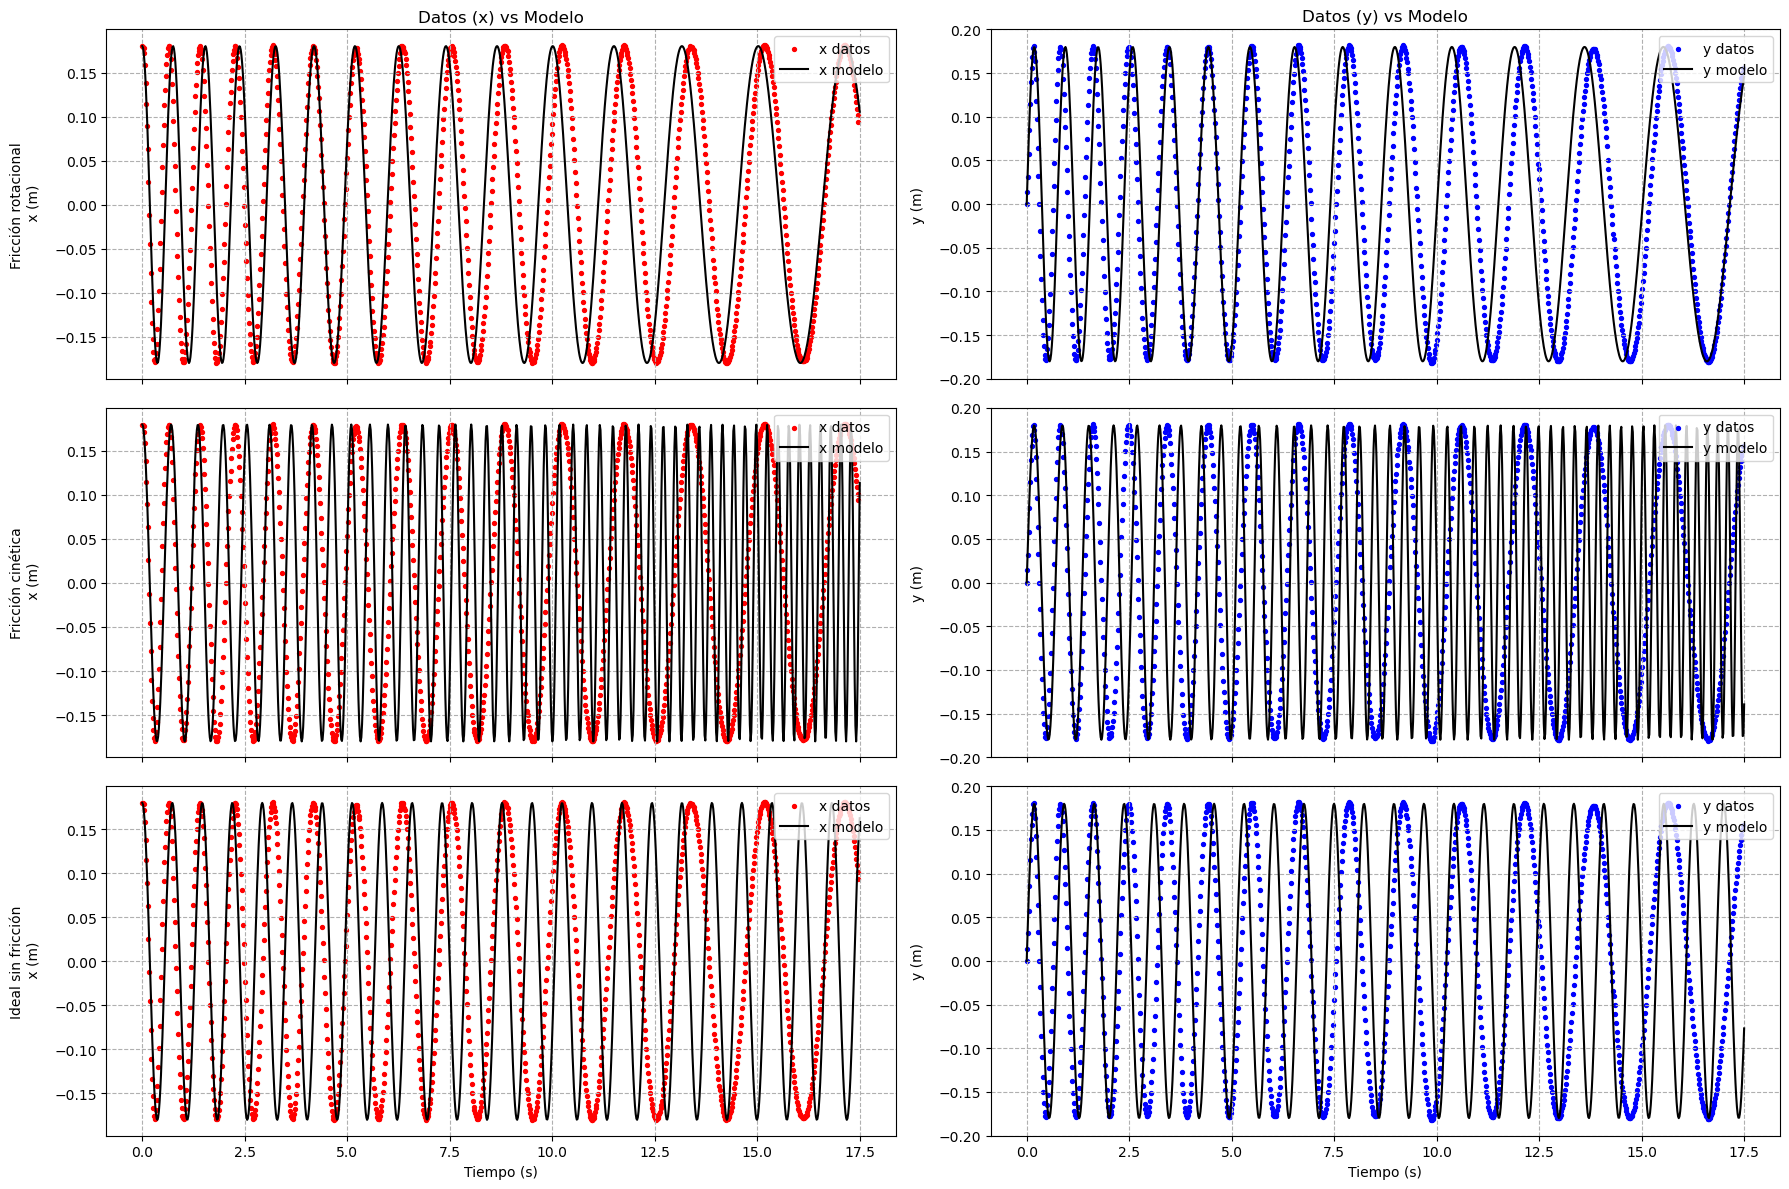

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

mat = [
    ("Fricción rotacional", x_rot, y_rot),
    ("Fricción cinética",   x_fk,  y_fk ),
    ("Ideal sin fricción",  x_id,  y_id )
]

for i, (label, x_mod, y_mod) in enumerate(mat):
    # --- x(t) ---
    axx = axes[i, 0]
    axx.scatter(t_exp, x_exp, color='red',  s=8,  label='x datos')
    axx.plot   (t_model, x_mod, color='black',      label='x modelo')
    axx.set_ylabel(f'{label}\n x (m)', rotation=90, labelpad=10)
    axx.grid(True, linestyle='--')
    axx.legend(loc='upper right')

    # --- y(t) ---
    axy = axes[i, 1]
    axy.scatter(t_exp, y_exp, color='blue', s=8,  label='y datos')
    axy.plot   (t_model, y_mod, color='black',      label='y modelo')
    axy.set_ylabel('y (m)', rotation=90, labelpad=10)
    axy.grid(True, linestyle='--')
    axy.legend(loc='upper right')

# Títulos y ejes comunes
axes[0, 0].set_title('Datos (x) vs Modelo')
axes[0, 1].set_title('Datos (y) vs Modelo')
axes[-1, 0].set_xlabel('Tiempo (s)')
axes[-1, 1].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

In [14]:
# ────────────────────────── Datos experimentales ─────────────────────────
df   = dfs[0]
t_e  = df['t'].values
ω_e  = df['v_ang'].values
m    = 0.0502
r    = 0.180
I    = 0.5 * m * r**2
df['L'] = I * ω_e            # momento angular experimental
L_e  = df['L'].values

# ────────────────────────── Parámetros modelo ────────────────────────────
ω0   = 8.6         # rad/s
β    = 0.066       # rotacional lineal
F0   = 1.2         # N
g    = 9.78
t_m  = np.linspace(0, 17.5, 1000)

# ───────────────────────── Modelos ω(t) ───────────────────────────────────
# 1) Rotacional exponencial (τ = -kω)
ω_rot = ω0 * np.exp(-β * t_m)
L_rot = I * ω_rot

# 2) Fricción cinética seca constante
μk       = 0.03                           # ajuste rápido
τ_c      = μk * m * g * r
α_fk     = -(τ_c / I)                     # desaceleración lineal
ω_fk     = np.maximum(ω0 + α_fk * t_m, 0) # corta en 0
L_fk     = I * ω_fk

# 3) Ideal sin fricción
ω_id  = np.full_like(t_m, ω0)             # constante
L_id  = I * ω_id

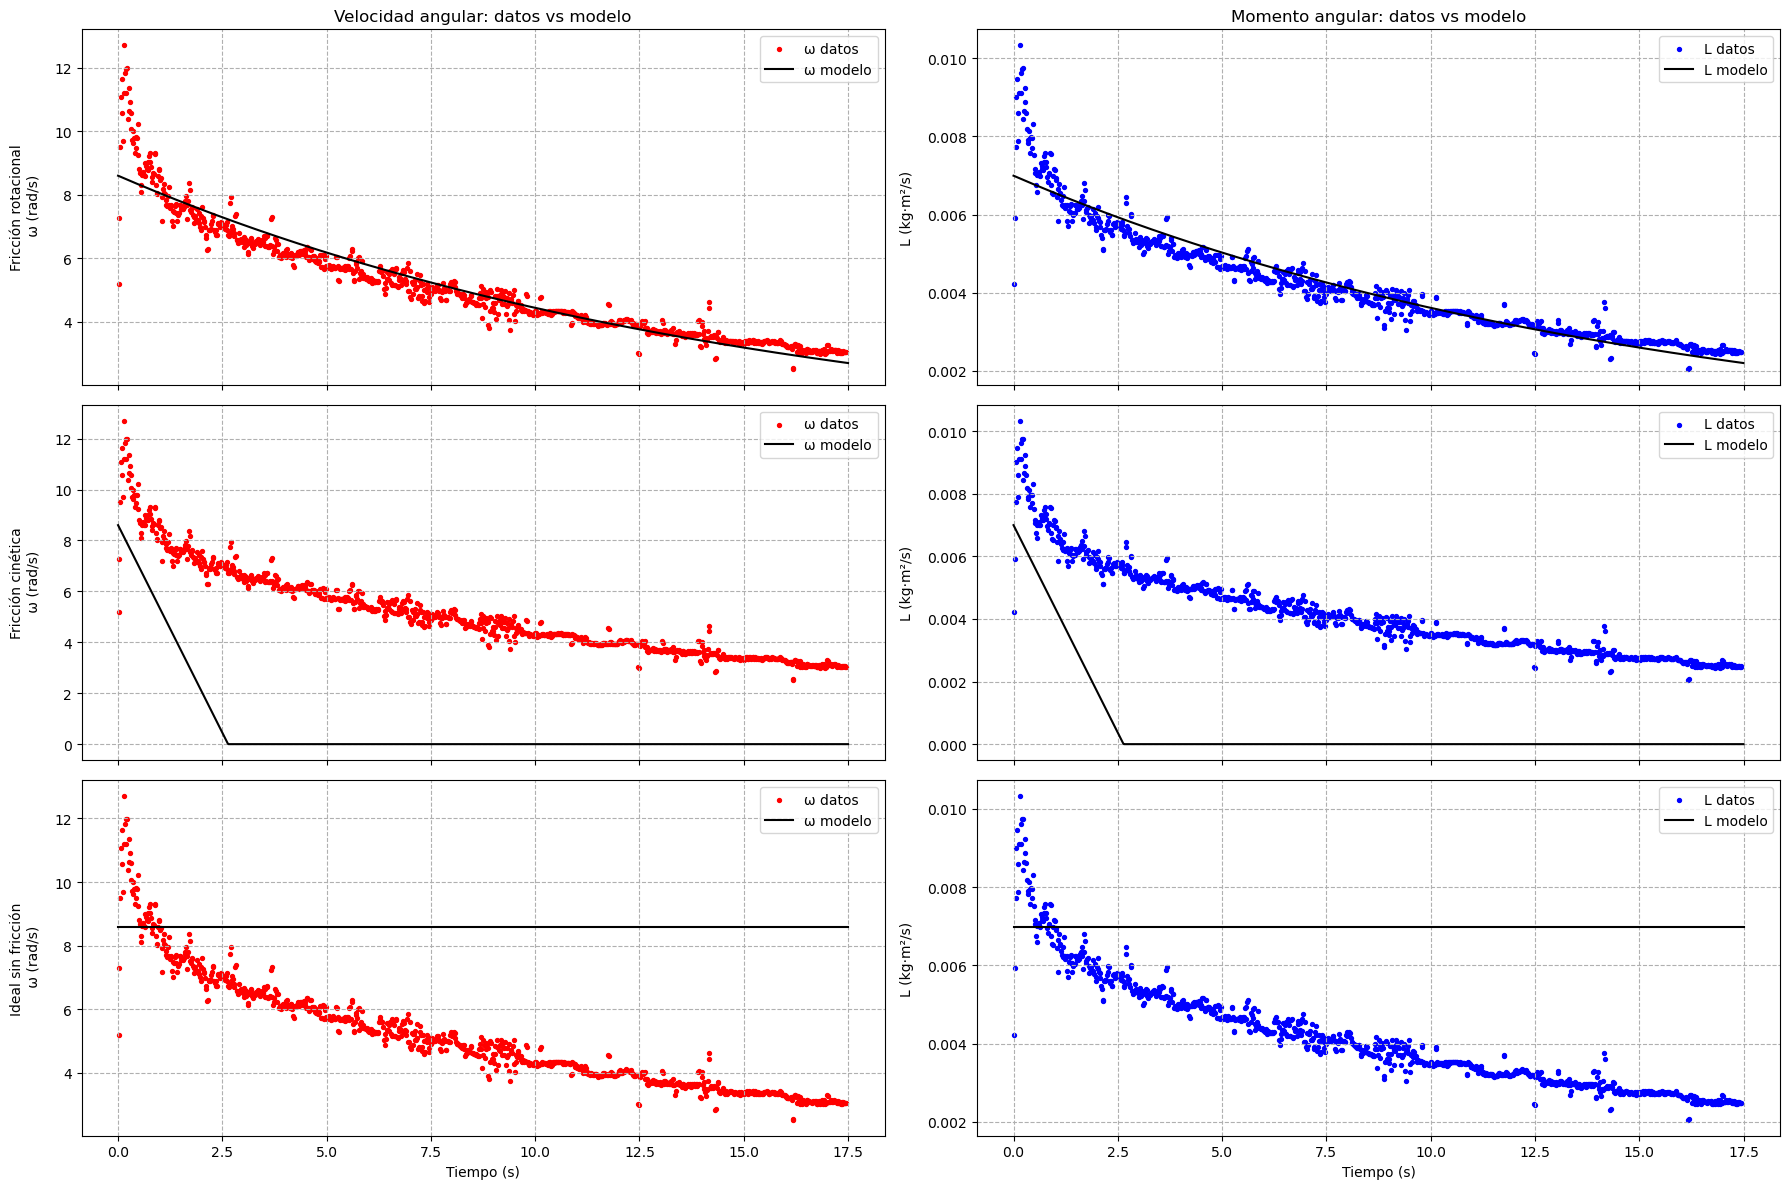

In [15]:
# ────────────────────────── Gráfica 3 × 2 ────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

mat = [
    ("Fricción rotacional", ω_rot, L_rot),
    ("Fricción cinética",   ω_fk, L_fk ),
    ("Ideal sin fricción",  ω_id, L_id )
]

for i, (label, ω_mod, L_mod) in enumerate(mat):
    # ─ ω(t) ─
    axω = axes[i, 0]
    axω.scatter(t_e, ω_e, color='red', s=8, label='ω datos')
    axω.plot(t_m, ω_mod, color='black', label='ω modelo')
    axω.set_ylabel(f'{label}\n ω (rad/s)', rotation=90, labelpad=10)
    axω.grid(True, linestyle='--')
    axω.legend(loc='upper right')

    # ─ L(t) ─
    axL = axes[i, 1]
    axL.scatter(t_e, L_e, color='blue', s=8, label='L datos')
    axL.plot(t_m, L_mod, color='black', label='L modelo')
    axL.set_ylabel('L (kg·m²/s)', rotation=90, labelpad=10)
    axL.grid(True, linestyle='--')
    axL.legend(loc='upper right')

# Etiquetas comunes
axes[-1, 0].set_xlabel('Tiempo (s)')
axes[-1, 1].set_xlabel('Tiempo (s)')
axes[0, 0].set_title('Velocidad angular: datos vs modelo')
axes[0, 1].set_title('Momento angular: datos vs modelo')

plt.tight_layout()
plt.show()

In [16]:
r0, lambda_ = radius_decay_constant(dfs[1])
print(f"Radio inicial estimado: {r0:.4f} m")
print(f"Constante de decaimiento λ: {lambda_:.4f} 1/s")

omega_0 = estimate_initial_omega(dfs[1])
print(f"ω₀ estimado: {omega_0:.4f} rad/s")

f_aplicada = initial_force_smooth(dfs[1], mass_kg=0.0502, t_max=0.3)
print(f"Fuerza inicial estimada (suave): {f_aplicada:.6f} N")

Radio inicial estimado: 0.1954 m
Constante de decaimiento λ: 0.3902 1/s
ω₀ estimado: 7.8961 rad/s
Fuerza inicial estimada (suave): 0.837901 N


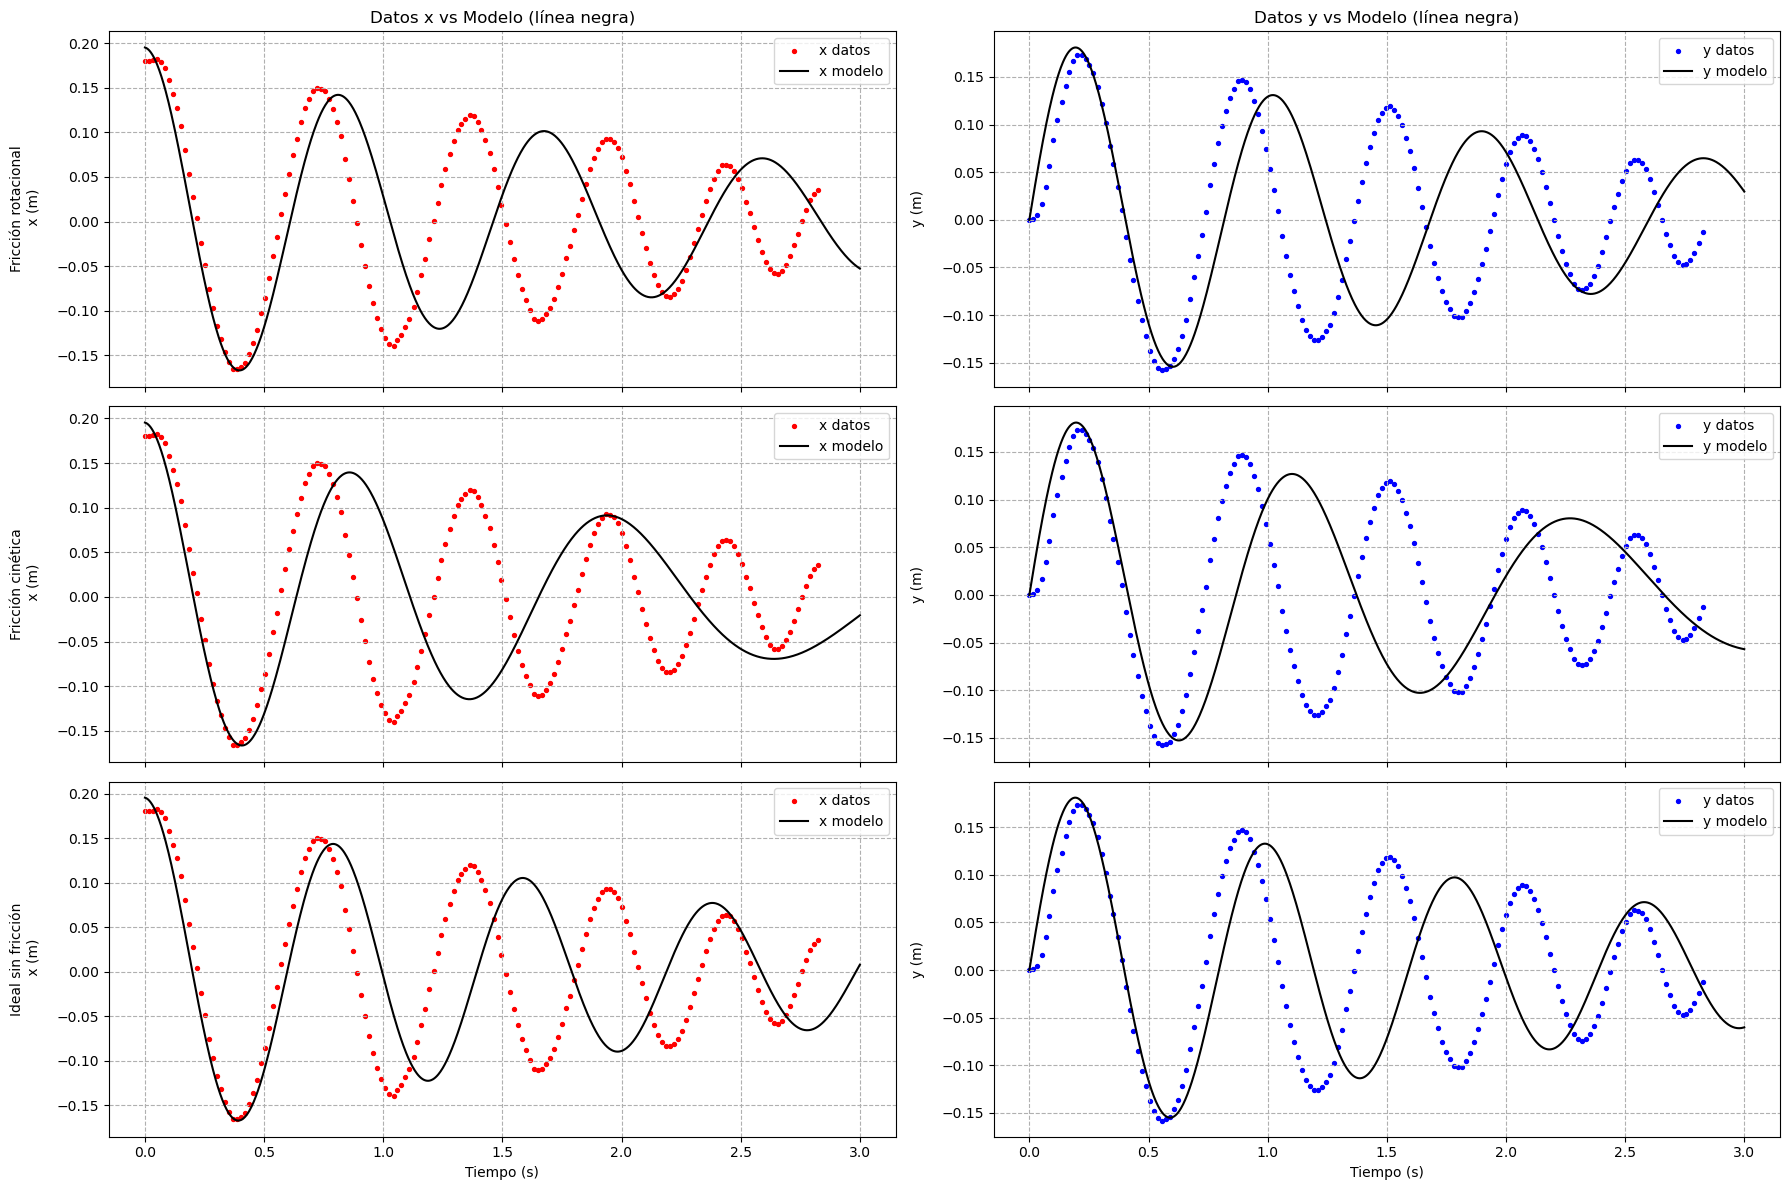

In [17]:
# ───────────────────── Datos experimentales (segunda tanda) ─────────────
df   = dfs[1]
t_e  = df['t'].values
x_e  = df['x'].values
y_e  = df['y'].values

# ───────────────────── Parámetros medidos / estimados ───────────────────
ω0      = 7.8961     # rad/s (ω inicial estimada)
β       = 0.0664     # 1/s   (decaimiento rotacional lineal)
r0      = 0.1954     # m     (radio inicial)
λ       = 0.3902     # 1/s   (decaimiento del radio)
F0      = 0.837901   # N     (fuerza de arranque)

m       = 0.0502     # kg
g       = 9.78       # m/s²
t_m     = np.linspace(0, 3, 1000)

# ───────────────────── Modelos x(t), y(t) ───────────────────────────────
r_t = r0 * np.exp(-λ * t_m)

# 1) Fricción rotacional (τ = -kω  ⇒  ω = ω0 e^{ -βt })
θ_rot = (ω0 / β) * (1 - np.exp(-β * t_m))
x_rot = r_t * np.cos(θ_rot)
y_rot = r_t * np.sin(θ_rot)

# 2) Fricción cinética seca (τ_c constante)  — ajuste rápido μ_k
μk   = 0.03                                    # puedes afinar
τ_c  = μk * m * g * r0                         # torque constante aprox.
α_fk = -(τ_c) / (m * r0**2)                    # ≈ -constante
θ_fk = ω0 * t_m + 0.5 * α_fk * t_m**2
x_fk = r_t * np.cos(θ_fk)
y_fk = r_t * np.sin(θ_fk)

# 3) Ideal sin fricción (MCU puro)   — ω(t) = ω0 constante
θ_id = ω0 * t_m
x_id = r_t * np.cos(θ_id)
y_id = r_t * np.sin(θ_id)

# ───────────────────── Gráfica 3 × 2 (x / y) ───────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

models = [
    ("Fricción rotacional", x_rot, y_rot),
    ("Fricción cinética",   x_fk,  y_fk ),
    ("Ideal sin fricción",  x_id,  y_id )
]

for i, (label, x_mod, y_mod) in enumerate(models):
    # ---- x(t) ----
    axx = axes[i, 0]
    axx.scatter(t_e, x_e, color='red',  s=8, label='x datos')
    axx.plot   (t_m, x_mod, color='black', label='x modelo')
    axx.set_ylabel(f'{label}\n x (m)', rotation=90, labelpad=12)
    axx.grid(True, linestyle='--')
    axx.legend(loc='upper right')

    # ---- y(t) ----
    axy = axes[i, 1]
    axy.scatter(t_e, y_e, color='blue', s=8, label='y datos')
    axy.plot   (t_m, y_mod, color='black', label='y modelo')
    axy.set_ylabel('y (m)', rotation=90, labelpad=12)
    axy.grid(True, linestyle='--')
    axy.legend(loc='upper right')

# Etiquetas y títulos comunes
axes[0, 0].set_title('Datos x vs Modelo (línea negra)')
axes[0, 1].set_title('Datos y vs Modelo (línea negra)')
axes[-1, 0].set_xlabel('Tiempo (s)')
axes[-1, 1].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

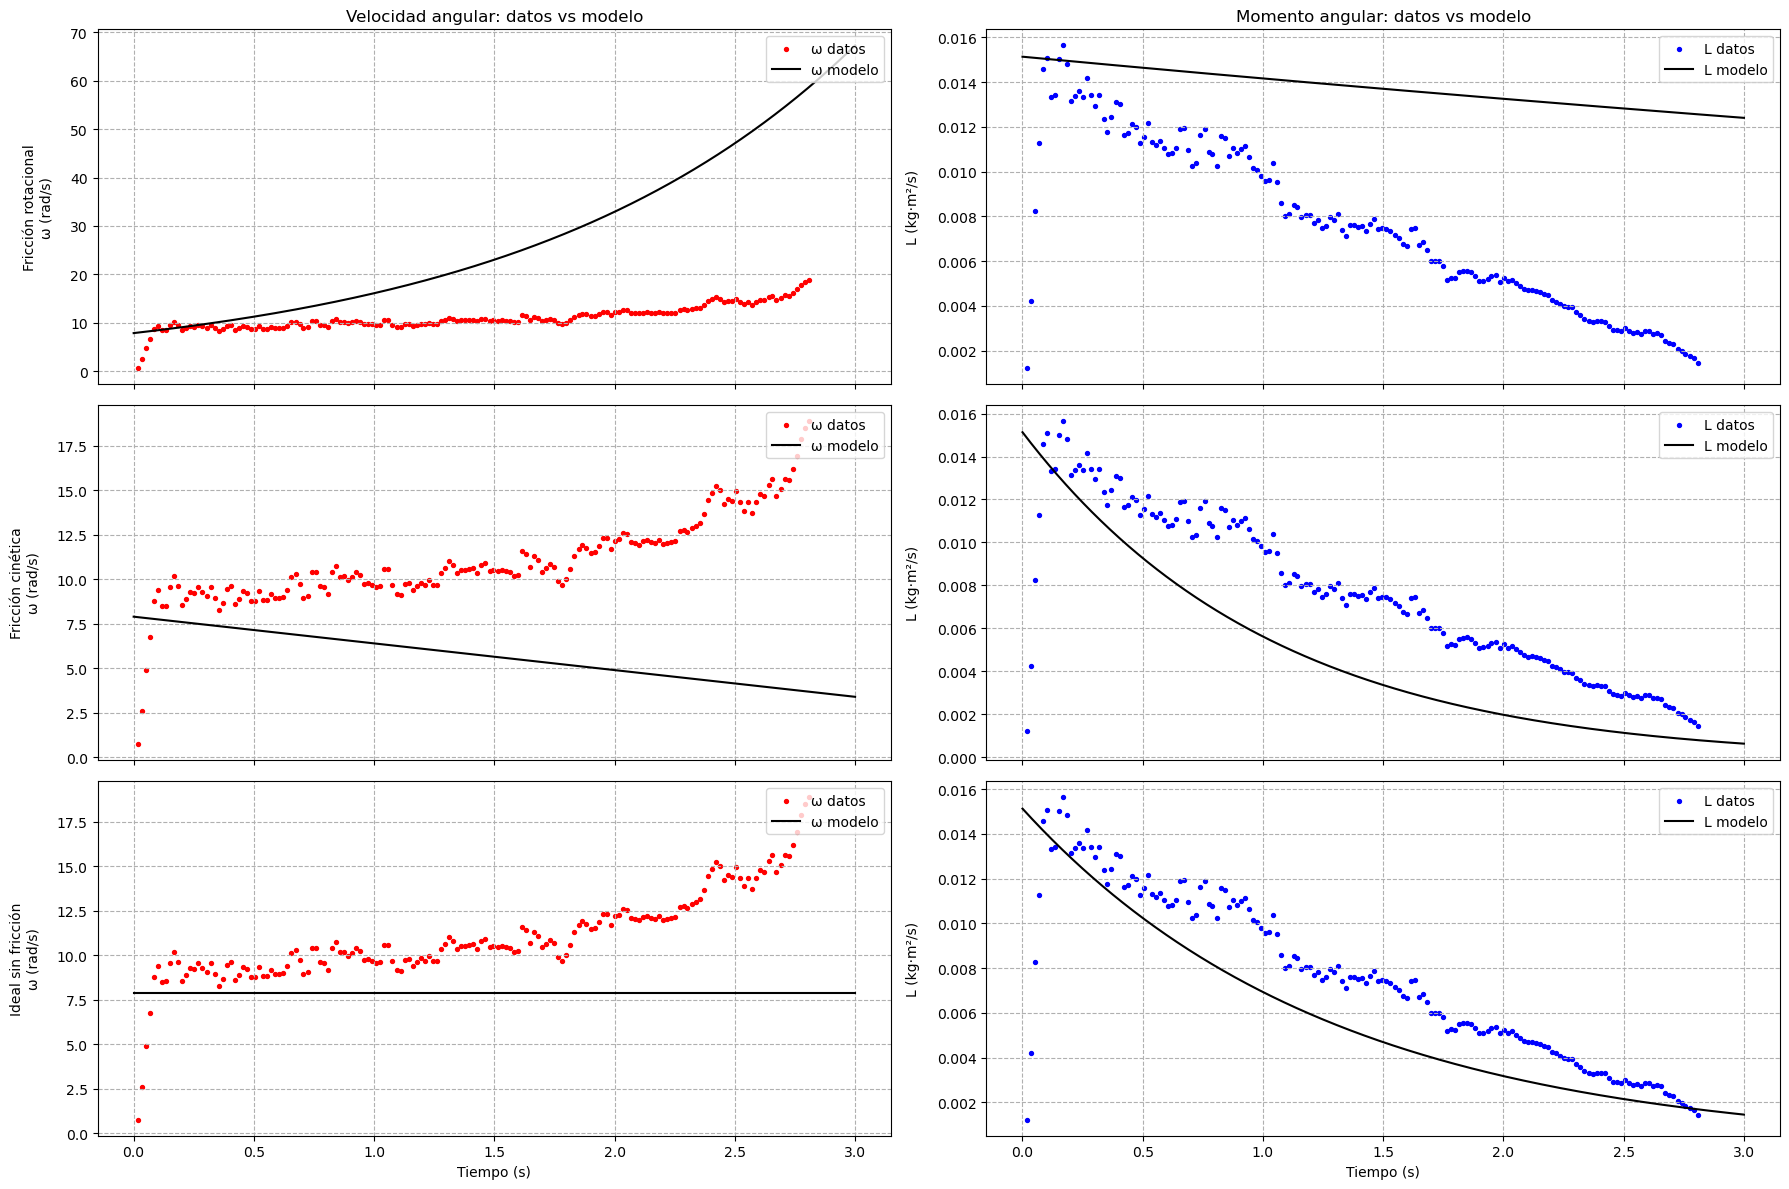

In [19]:
# ──────────────────────────── datos experimentales ──────────────────────
df  = dfs[1]
t_e = df['t'].values
ω_e = df['v_ang'].values
r_e = df['r'].values
m   = 0.0502
L_e = m * r_e**2 * ω_e                      # momento angular real

# ───────────────────── parámetros medidos / estimados ───────────────────
ω0  = 7.8961      # rad/s  velocidad inicial
β   = 0.0664      # 1/s    amortiguamiento lineal (rot.)
r0  = 0.1954      # m
λ   = 0.3902      # 1/s    decaimiento del radio
F0  = 0.837901    # N
g   = 9.78        # m/s²
t_m = np.linspace(0, 3, 1000)
r_t = r0 * np.exp(-λ * t_m)

# ───────────────────── modelo 1 · fricción rotacional + radio ↓ ─────────
#   I = m r² ,  dL/dt = -k ω  →     ω(t) = ω0 · e^{(2λ - β) t}
ω_rot = ω0 * np.exp((2*λ - β) * t_m)        # aumenta porque 2λ > β
# integrar para θ
θ_rot = ω0/(2*λ - β) * (np.exp((2*λ - β)*t_m) - 1)
x_rot = r_t * np.cos(θ_rot)
y_rot = r_t * np.sin(θ_rot)
L_rot = m * r_t**2 * ω_rot

# ───────────────────── modelo 2 · fricción cinética (τc cte) ────────────
μk   = 0.03                                # ajuste rápido
τc   = μk * m * g * r0
α_fk = -τc / (m * r0**2)                   # desacel. angular lineal
ω_fk = np.maximum(ω0 + α_fk * t_m, 0)
θ_fk = ω0 * t_m + 0.5 * α_fk * t_m**2
x_fk = r_t * np.cos(θ_fk)
y_fk = r_t * np.sin(θ_fk)
L_fk = m * r_t**2 * ω_fk

# ───────────────────── modelo 3 · ideal (MCU, sin fricción) ─────────────
ω_id = np.full_like(t_m, ω0)
θ_id = ω0 * t_m
x_id = r_t * np.cos(θ_id)
y_id = r_t * np.sin(θ_id)
L_id = m * r_t**2 * ω_id

# ────────────────────── figura 3 × 2 (ω / L) ────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

models = [
    ("Fricción rotacional", ω_rot, L_rot),
    ("Fricción cinética",   ω_fk,  L_fk ),
    ("Ideal sin fricción",  ω_id,  L_id )
]

for i, (label, ω_mod, L_mod) in enumerate(models):
    # velocidad angular
    axω = axes[i, 0]
    axω.scatter(t_e, ω_e, color='red', s=8, label='ω datos')
    axω.plot(t_m, ω_mod, color='black', label='ω modelo')
    axω.set_ylabel(f'{label}\nω (rad/s)', rotation=90, labelpad=12)
    axω.grid(True, linestyle='--')
    axω.legend(loc='upper right')

    # momento angular
    axL = axes[i, 1]
    axL.scatter(t_e, L_e, color='blue', s=8, label='L datos')
    axL.plot(t_m, L_mod, color='black', label='L modelo')
    axL.set_ylabel('L (kg·m²/s)', rotation=90, labelpad=12)
    axL.grid(True, linestyle='--')
    axL.legend(loc='upper right')

axes[0, 0].set_title('Velocidad angular: datos vs modelo')
axes[0, 1].set_title('Momento angular: datos vs modelo')
axes[-1, 0].set_xlabel('Tiempo (s)')
axes[-1, 1].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

In [20]:
r0, lambda_ = radius_decay_constant(dfs[2])
print(f"Radio inicial estimado: {r0:.4f} m")
print(f"Constante de decaimiento λ: {lambda_:.4f} 1/s")

omega_0 = estimate_initial_omega(dfs[2])
print(f"ω₀ estimado: {omega_0:.4f} rad/s")

f_aplicada = initial_force_smooth(dfs[2], mass_kg=0.0502, t_max=0.3)
print(f"Fuerza inicial estimada (suave): {f_aplicada:.6f} N")

Radio inicial estimado: 0.1983 m
Constante de decaimiento λ: 0.2262 1/s
ω₀ estimado: 4.8476 rad/s
Fuerza inicial estimada (suave): 0.319727 N


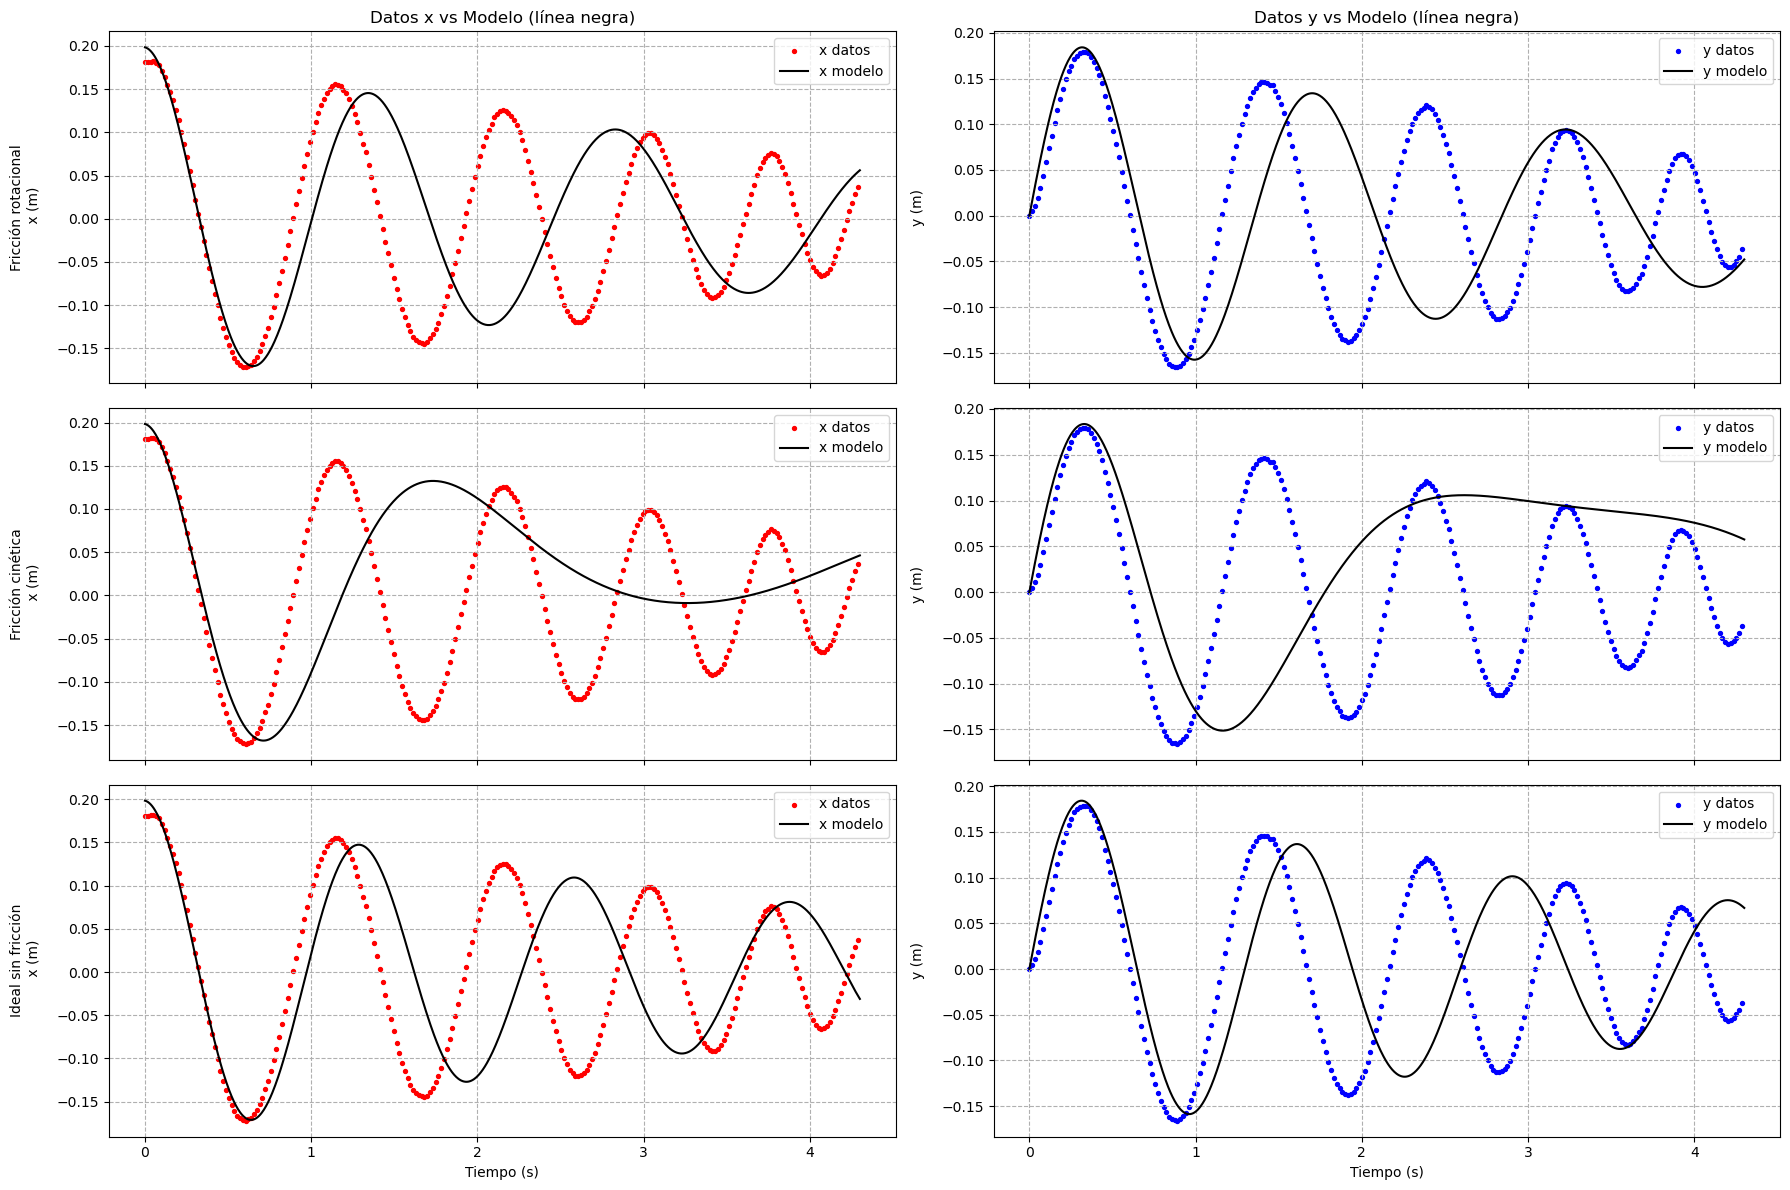

In [25]:
# ───────────────────── Datos experimentales (segunda tanda) ─────────────
df   = dfs[2]
t_e  = df['t'].values
x_e  = df['x'].values
y_e  = df['y'].values

# ───────────────────── Parámetros medidos / estimados ───────────────────
ω0      = 4.85    # rad/s (ω inicial estimada)
β       = 0.0664     # 1/s   (decaimiento rotacional lineal)
r0      = 0.1983     # m     (radio inicial)
λ       = 0.23     # 1/s   (decaimiento del radio)
F0      = 0.32   # N     (fuerza de arranque)

m       = 0.0502     # kg
g       = 9.78       # m/s²
t_m     = np.linspace(0, 4.3, 1000)

# ───────────────────── Modelos x(t), y(t) ───────────────────────────────
r_t = r0 * np.exp(-λ * t_m)

# 1) Fricción rotacional (τ = -kω  ⇒  ω = ω0 e^{ -βt })
θ_rot = (ω0 / β) * (1 - np.exp(-β * t_m))
x_rot = r_t * np.cos(θ_rot)
y_rot = r_t * np.sin(θ_rot)

# 2) Fricción cinética seca (τ_c constante)  — ajuste rápido μ_k
μk   = 0.03                                    # puedes afinar
τ_c  = μk * m * g * r0                         # torque constante aprox.
α_fk = -(τ_c) / (m * r0**2)                    # ≈ -constante
θ_fk = ω0 * t_m + 0.5 * α_fk * t_m**2
x_fk = r_t * np.cos(θ_fk)
y_fk = r_t * np.sin(θ_fk)

# 3) Ideal sin fricción (MCU puro)   — ω(t) = ω0 constante
θ_id = ω0 * t_m
x_id = r_t * np.cos(θ_id)
y_id = r_t * np.sin(θ_id)

# ───────────────────── Gráfica 3 × 2 (x / y) ───────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

models = [
    ("Fricción rotacional", x_rot, y_rot),
    ("Fricción cinética",   x_fk,  y_fk ),
    ("Ideal sin fricción",  x_id,  y_id )
]

for i, (label, x_mod, y_mod) in enumerate(models):
    # ---- x(t) ----
    axx = axes[i, 0]
    axx.scatter(t_e, x_e, color='red',  s=8, label='x datos')
    axx.plot   (t_m, x_mod, color='black', label='x modelo')
    axx.set_ylabel(f'{label}\n x (m)', rotation=90, labelpad=12)
    axx.grid(True, linestyle='--')
    axx.legend(loc='upper right')

    # ---- y(t) ----
    axy = axes[i, 1]
    axy.scatter(t_e, y_e, color='blue', s=8, label='y datos')
    axy.plot   (t_m, y_mod, color='black', label='y modelo')
    axy.set_ylabel('y (m)', rotation=90, labelpad=12)
    axy.grid(True, linestyle='--')
    axy.legend(loc='upper right')

# Etiquetas y títulos comunes
axes[0, 0].set_title('Datos x vs Modelo (línea negra)')
axes[0, 1].set_title('Datos y vs Modelo (línea negra)')
axes[-1, 0].set_xlabel('Tiempo (s)')
axes[-1, 1].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

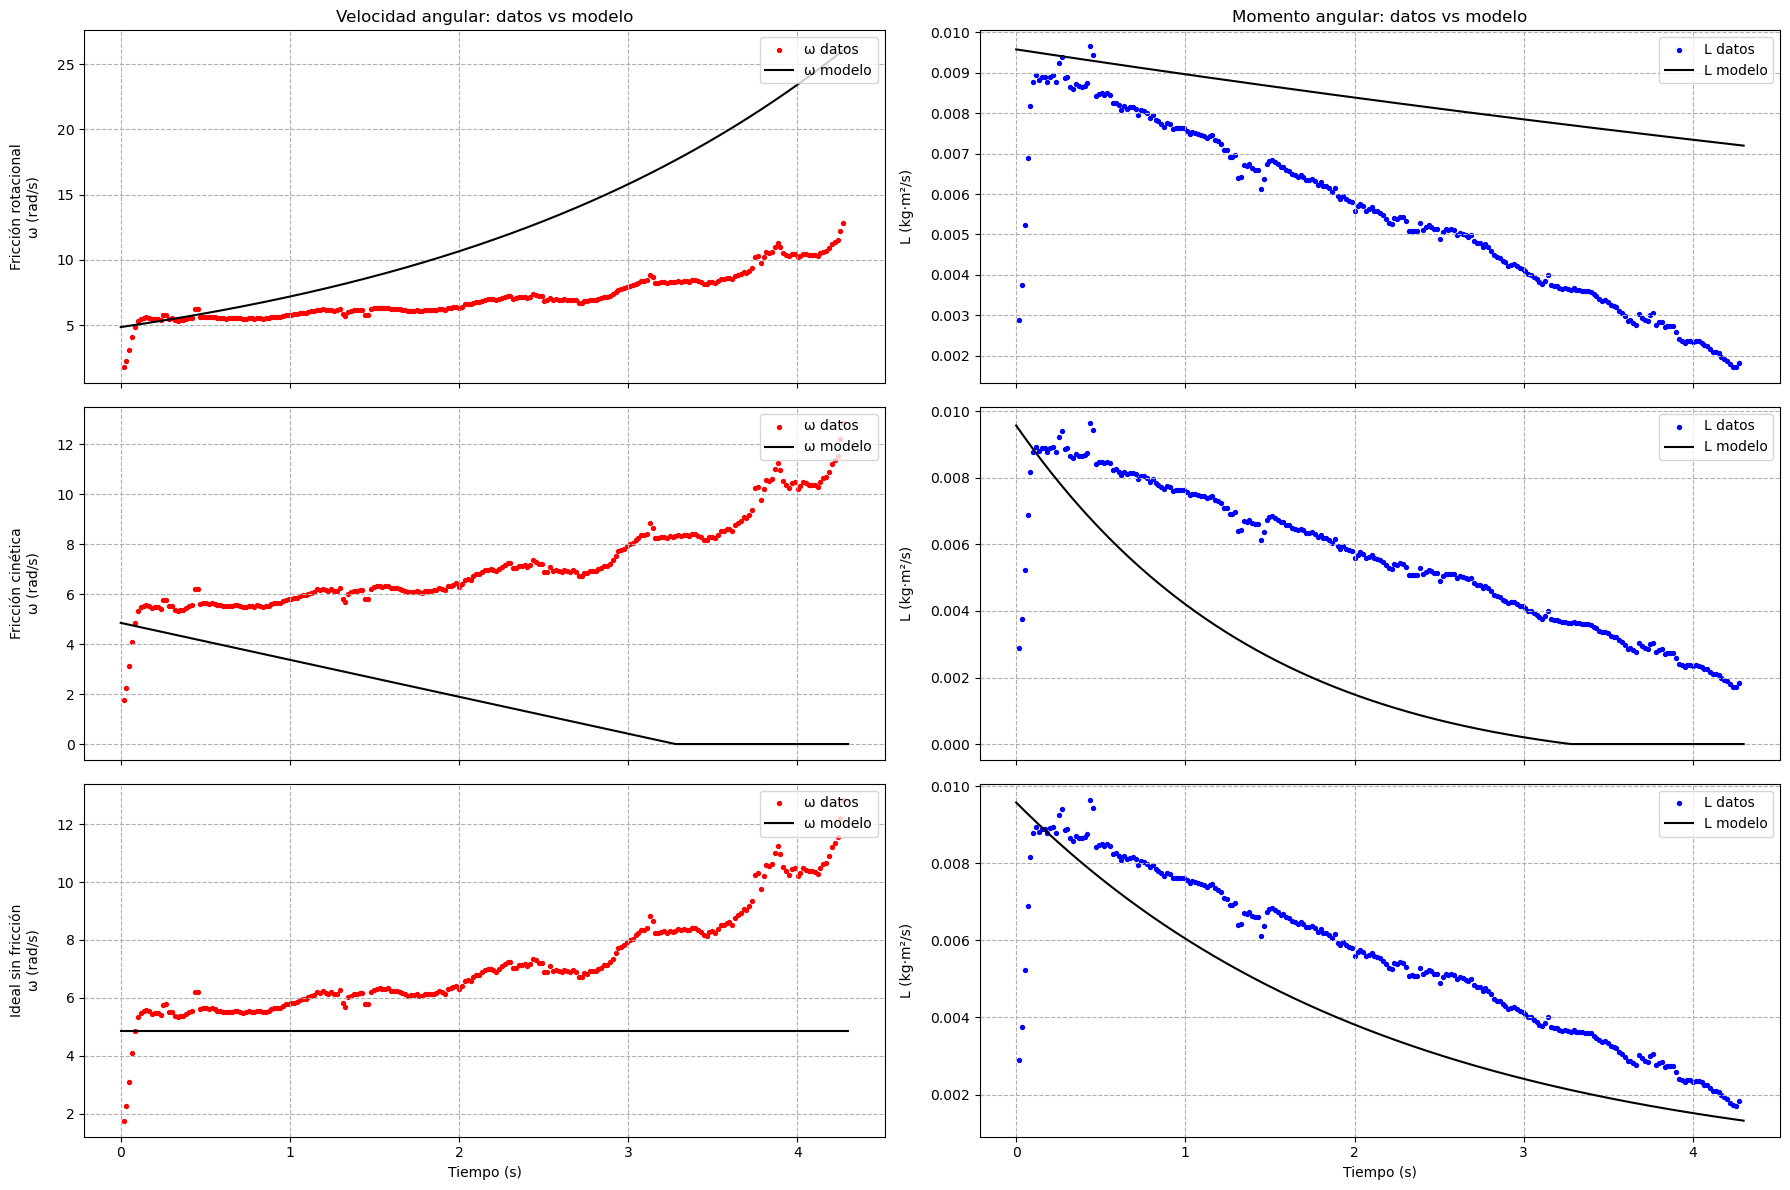

In [27]:
# ──────────────────────────── datos experimentales ──────────────────────
df  = dfs[2]
t_e = df['t'].values
ω_e = df['v_ang'].values
r_e = df['r'].values
m   = 0.0502
L_e = m * r_e**2 * ω_e                      # momento angular real

# ───────────────────── parámetros medidos / estimados ───────────────────
ω0      = 4.85    # rad/s (ω inicial estimada)
β       = 0.0664     # 1/s   (decaimiento rotacional lineal)
r0      = 0.1983     # m     (radio inicial)
λ       = 0.23     # 1/s   (decaimiento del radio)
F0      = 0.32   # N     (fuerza de arranque)
m       = 0.0502     # kg
g       = 9.78       # m/s²
t_m = np.linspace(0, 4.3, 1000)
r_t = r0 * np.exp(-λ * t_m)

# ───────────────────── modelo 1 · fricción rotacional + radio ↓ ─────────
#   I = m r² ,  dL/dt = -k ω  →     ω(t) = ω0 · e^{(2λ - β) t}
ω_rot = ω0 * np.exp((2*λ - β) * t_m)        # aumenta porque 2λ > β
# integrar para θ
θ_rot = ω0/(2*λ - β) * (np.exp((2*λ - β)*t_m) - 1)
x_rot = r_t * np.cos(θ_rot)
y_rot = r_t * np.sin(θ_rot)
L_rot = m * r_t**2 * ω_rot

# ───────────────────── modelo 2 · fricción cinética (τc cte) ────────────
μk   = 0.03                                # ajuste rápido
τc   = μk * m * g * r0
α_fk = -τc / (m * r0**2)                   # desacel. angular lineal
ω_fk = np.maximum(ω0 + α_fk * t_m, 0)
θ_fk = ω0 * t_m + 0.5 * α_fk * t_m**2
x_fk = r_t * np.cos(θ_fk)
y_fk = r_t * np.sin(θ_fk)
L_fk = m * r_t**2 * ω_fk

# ───────────────────── modelo 3 · ideal (MCU, sin fricción) ─────────────
ω_id = np.full_like(t_m, ω0)
θ_id = ω0 * t_m
x_id = r_t * np.cos(θ_id)
y_id = r_t * np.sin(θ_id)
L_id = m * r_t**2 * ω_id

# ────────────────────── figura 3 × 2 (ω / L) ────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

models = [
    ("Fricción rotacional", ω_rot, L_rot),
    ("Fricción cinética",   ω_fk,  L_fk ),
    ("Ideal sin fricción",  ω_id,  L_id )
]

for i, (label, ω_mod, L_mod) in enumerate(models):
    # velocidad angular
    axω = axes[i, 0]
    axω.scatter(t_e, ω_e, color='red', s=8, label='ω datos')
    axω.plot(t_m, ω_mod, color='black', label='ω modelo')
    axω.set_ylabel(f'{label}\nω (rad/s)', rotation=90, labelpad=12)
    axω.grid(True, linestyle='--')
    axω.legend(loc='upper right')

    # momento angular
    axL = axes[i, 1]
    axL.scatter(t_e, L_e, color='blue', s=8, label='L datos')
    axL.plot(t_m, L_mod, color='black', label='L modelo')
    axL.set_ylabel('L (kg·m²/s)', rotation=90, labelpad=12)
    axL.grid(True, linestyle='--')
    axL.legend(loc='upper right')

axes[0, 0].set_title('Velocidad angular: datos vs modelo')
axes[0, 1].set_title('Momento angular: datos vs modelo')
axes[-1, 0].set_xlabel('Tiempo (s)')
axes[-1, 1].set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()